## **Machine Learning Zoomcamp 2025**

## **Homework 4**

In [74]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-11-15 14:42:05--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.6’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.02s   

2025-11-15 14:42:05 (3.69 MB/s) - ‘course_lead_scoring.csv.6’ saved [80876/80876]



In [75]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [76]:
df = pd.read_csv('course_lead_scoring.csv')

In [77]:
df.dtypes

,0
lead_source,object
industry,object
number_of_courses_viewed,int64
annual_income,float64
employment_status,object
location,object
interaction_count,int64
lead_score,float64
converted,int64


**Data Preparation**

Check if the missing values are presented in the features.

If there are missing values:

*  For categorical features, replace them with 'NA'
*  For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
  df[c] = df[c].fillna('NA')

numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

for c in numerical_columns:
  df[c] = df[c].fillna(0.0)

In [80]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

**Question 1: ROC AUC feature importance**

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* lead_score
* number_of_courses_viewed
* interaction_count
* annual_income

In [81]:
from sklearn.metrics import roc_auc_score

In [82]:
auc_scores = {}
numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for feature in numerical_features:
    feature_values = df_train[feature].values
    auc = roc_auc_score(y_train, feature_values)

    if auc < 0.5:
        auc = roc_auc_score(y_train, -feature_values)
    auc_scores[feature] = auc

print("AUC scores for numerical features:")
for feature, score in auc_scores.items():
    print(f"{feature}: {score:.4f}")

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical feature with the highest AUC is: {best_feature}")


AUC scores for numerical features:
lead_score: 0.6145
number_of_courses_viewed: 0.7636
interaction_count: 0.7383
annual_income: 0.5520

The numerical feature with the highest AUC is: number_of_courses_viewed


**Question 2**

Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.32
* 0.52
* 0.72
* 0.92


In [83]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [84]:
dv = DictVectorizer(sparse = False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on validation dataset: {auc:.3f}")

AUC on validation dataset: 0.817


**The AUC of this model on the validation dataset is *"0.72 and 0.92."***

**Question 3 Precision and Recall**

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01.

For each threshold, compute precision and recall
Plot them. At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

/tmp/ipython-input-793021035.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


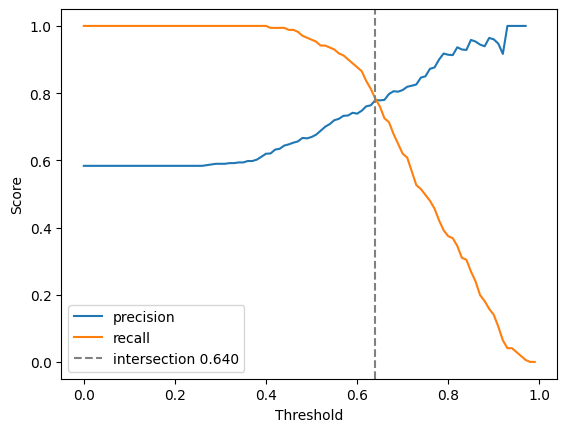

In [85]:
thresholds = np.arange(0.0, 1.00, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * (p * r) / (p + r)
    scores.append((t, p, r, f1))

columns = ['thresholds', 'precision', 'recall', 'f1 score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['diff'] = abs(df_scores['precision'] - df_scores['recall'])
intersection_threshold = df_scores.loc[df_scores['diff'].idxmin(), 'thresholds']

plt.plot(df_scores.thresholds, df_scores['precision'], label='precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='recall')
plt.axvline(intersection_threshold, color='gray', linestyle='--', label=f'intersection {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

**Question 4: F1 score**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2. (P.R) / (P + R)

Where
P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.14
* 0.34
* 0.54
* 0.74

In [86]:
max_threshold = df_scores.loc[df_scores['f1 score'].idxmax(), 'thresholds']
print(max_threshold.round(2))


0.57


***At threshold = 0.54*, F1 is maximal.**

**Question 5: 5-Fold CV**

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train.

Split the data into train and validation.

Train the model on train with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation.

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.36

In [87]:
from sklearn.model_selection import KFold

import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv = DictVectorizer(sparse=False)

    X_train = dv.fit_transform(df_train.to_dict(orient='records'))
    X_val = dv.transform(df_val.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'The standard deviation of the scores across different folds is ',np.std(scores).round(4))


The standard deviation of the scores across different folds is  0.0318


**Question 6: Hyperparameter Tuning**

Now let's use 5-Fold cross-validation to find the best parameter C.

Iterate over the following C values: [0.000001, 0.001, 1].

Initialize KFold with the same parameters as previously.

Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000).

Compute the mean score as well as the std (round the mean and std to 3 decimal digits).

Which C leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [88]:
C = [0.000001, 0.001, 1]

for c in C:
  scores = []

  for train_idx, val_idx in kfold.split(df_full_train):

      df_train = df_full_train.iloc[train_idx]
      df_val = df_full_train.iloc[val_idx]

      y_train = df_train.converted.values
      y_val = df_val.converted.values

      dv = DictVectorizer(sparse=False)

      X_train = dv.fit_transform(df_train.to_dict(orient='records'))
      X_val = dv.transform(df_val.to_dict(orient='records'))

      model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
      model.fit(X_train, y_train)

      y_pred = model.predict_proba(X_val)[:, 1]

      auc = roc_auc_score(y_val, y_pred)
      scores.append(auc)

  print('c=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))


c=1e-06 0.561 +- 0.024
c=0.001 0.926 +- 0.018
c=1 0.876 +- 0.032


***"C = 0.001"* leads to the best mean score.**